In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# How were the features extracted?

In [26]:
with open('python/methods.py', 'r') as file:
    exec(file.read())

In [27]:
data = pd.read_pickle('output/problem-at-hand/S2/run9/mne_good_channels.pkl')
events = pd.read_pickle('output/problem-at-hand/S2/run9/events.pkl')
events = events.drop(index = [0, 1]).reset_index(drop = True)

In [28]:
# Settings from config
feature_length = 0.25
min_freq = 5
max_freq = 100
freq_step = 5
relative_frequency = False

First, the events were cropped into shorter events. If it was impossible to crop the event nicely (impossible to divide the time evenly), half of the remainder time was cropped from both sides. Then, the event was divided into fragments of 0.25 seconds.

In [29]:
event_zero = events.iloc[0]
event_zero

Start         6.2
End           9.3
Event         0.0
Length        3.1
EventID    Event2
Name: 0, dtype: object

In [30]:
normalized_events = normalize_events(events, feature_length = feature_length)
normalized_event_zero = normalized_events[normalized_events['OriginalEventID'] == event_zero['EventID']]
normalized_event_zero

,Start,End,Event,Length,OriginalEventID,EventID
0,6.25,6.50,0.0,0.25,Event2,Event0
1,6.50,6.75,0.0,0.25,Event2,Event1
2,6.75,7.00,0.0,0.25,Event2,Event2
3,7.00,7.25,0.0,0.25,Event2,Event3
4,7.25,7.50,0.0,0.25,Event2,Event4
5,7.50,7.75,0.0,0.25,Event2,Event5
6,7.75,8.00,0.0,0.25,Event2,Event6
7,8.00,8.25,0.0,0.25,Event2,Event7
8,8.25,8.50,0.0,0.25,Event2,Event8
9,8.50,8.75,0.0,0.25,Event2,Event9


The frequency range of interest was created (from 5 Hz to 100 Hz, with a step of 5 Hz).

In [31]:
freq_range = np.arange(min_freq, max_freq, freq_step)
freq_range

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])

In [32]:
event = normalized_event_zero.iloc[5]
event  # Will process this event

Start                 7.5
End                  7.75
Event                 0.0
Length               0.25
OriginalEventID    Event2
EventID            Event5
Name: 5, dtype: object

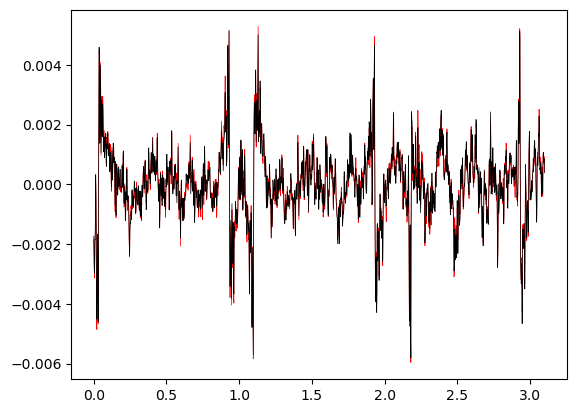

In [33]:
event_data = data.copy().crop(tmin = event_zero['Start'], tmax = event_zero['End'])

plt.plot(event_data.times, event_data.get_data()[255, :], c = 'red', linewidth = 0.5)
plt.plot(event_data.times, event_data.get_data()[150, :], c = 'black', linewidth = 0.5)
plt.show()

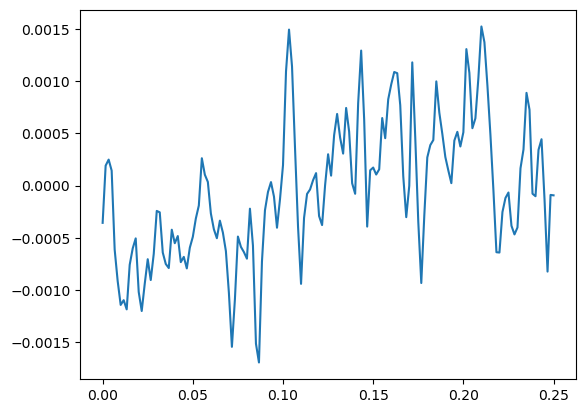

In [34]:
event_data = data.copy().crop(tmin = event['Start'], tmax = event['End'])

plt.plot(event_data.times, np.mean(event_data.get_data(), axis = 0))
plt.show()

In [35]:
channel = 60
freq = 75

data = event_data.get_data(picks = [channel])[0]
sf = event_data.info['sfreq']
low = freq
high = freq + freq_step
min_freq = min_freq
max_freq = max_freq
relative = relative_frequency

In [36]:
from scipy.signal import welch
from scipy.integrate import simps
import numpy as np

In [37]:
nperseg = 150

In [38]:
freqs, psd = welch(data, sf, nperseg = nperseg)
freq_res = freqs[1] - freqs[0]
idx_band = np.logical_and(freqs >= low, freqs <= high)
bp = simps(psd[idx_band], dx = freq_res)

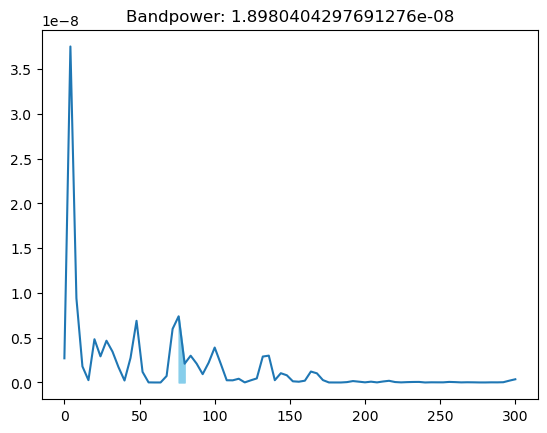

In [39]:
plt.plot(freqs, psd)
plt.fill_between(freqs, psd, where = idx_band, color = 'skyblue')
plt.title(f'Bandpower: {bp}')
plt.show()

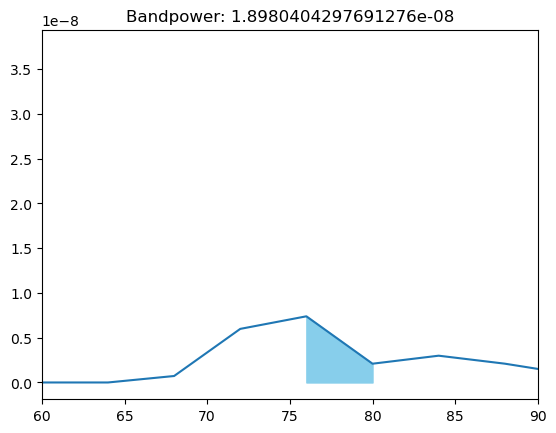

In [40]:
plt.plot(freqs, psd)
plt.fill_between(freqs, psd, where = idx_band, color = 'skyblue')
plt.xlim(60, 90)
plt.title(f'Bandpower: {bp}')
plt.show()

In [41]:
final_features = pd.read_csv('output/problem-at-hand/S2/run9/features.csv')
final_features = final_features[final_features['Channel'] == 'X60']
final_features = final_features[final_features['Frequency'] == 75]
original_bp = final_features[final_features['EventID'] == event['EventID']]['Feature'].iloc[0]

In [42]:
bp == original_bp

True

# Why are some features all zeros?..

In [43]:
feature_matrix = pd.read_csv('output/problem-at-hand/S2/all/feature_matrix.csv', index_col = 0)
key = pd.read_csv('output/problem-at-hand/S2/all/key.csv')

def extract_feature_channel(row):
    return re.sub('X([0-9]+)_[0-9]+', '\\1', row['FeatureID'])


def extract_feature_frequency(row):
    return re.sub('X[0-9]+_([0-9]+)', '\\1', row['FeatureID'])


feature_info = pd.DataFrame(feature_matrix.index)
feature_info['Channel'] = feature_info.apply(extract_feature_channel, axis = 1)
feature_info['Frequency'] = feature_info.apply(extract_feature_frequency, axis = 1)
feature_info['Frequency'] = feature_info['Frequency'].astype('int', copy = False)

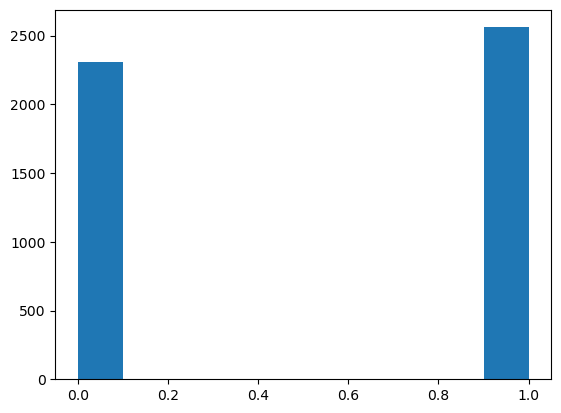

In [44]:
zero_percentage = np.mean(feature_matrix == 0, axis = 1)

plt.hist(zero_percentage)
plt.show()

A bunch of features are all zeros. Why?

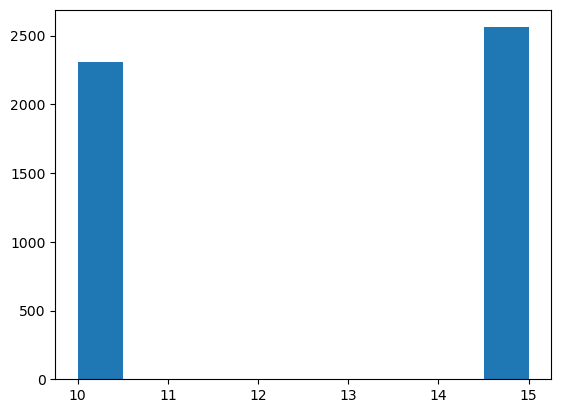

In [45]:
plt.hist(feature_info.iloc[zero_percentage]['Frequency'])
plt.show()

They are either in frequency range 10-15 or 15-20 Hz. What is happening there?

In [46]:
# Settings from config
feature_length = 0.25
min_freq = 4
max_freq = 100
freq_step = 4
relative_frequency = False

freq = 4

In [47]:
data = event_data.get_data(picks = [channel])[0]
sf = event_data.info['sfreq']
low = freq
high = freq + freq_step
min_freq = min_freq
max_freq = max_freq

freqs, psd = welch(data, sf, nperseg = nperseg)
freq_res = freqs[1] - freqs[0]
idx_band = np.logical_and(freqs >= low, freqs <= high)
bp = simps(psd[idx_band], dx = freq_res)

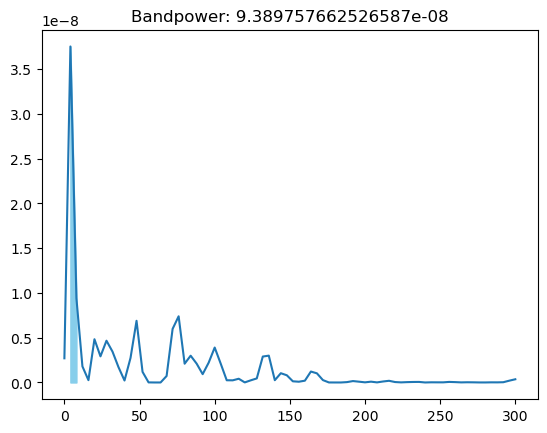

In [48]:
plt.plot(freqs, psd)
plt.fill_between(freqs, psd, where = idx_band, color = 'skyblue')
plt.title(f'Bandpower: {bp}')
plt.show()

Solution is to update the parameters. Everything seems fine!